In [3]:
# !pip install -q d3rlpy==2.5.0
# !pip install -q gymnasium==0.29.1

In [36]:
import os
import warnings
import numpy as np
import pandas as pd
import joblib
import torch
warnings.filterwarnings("ignore")

print("="*60)
print("REINFORCEMENT LEARNING POLICY TRAINING")
print("="*60)

# Import d3rlpy
import d3rlpy
from d3rlpy.dataset import MDPDataset
print(f"d3rlpy version: {d3rlpy.__version__}")

# Import CQL - try both ways
try:
    from d3rlpy.algos import DiscreteCQLConfig as CQLConfig
    print("Imported DiscreteCQLConfig")
except:
    from d3rlpy.algos import CQLConfig
    print("Imported CQLConfig")

SEED = 42
np.random.seed(SEED)

# Paths
ACC_PATH = "/kaggle/input/lending-club-accepted-2007-to-2018/accepted_2007_to_2018Q4.csv"
REJ_PATH = "/kaggle/input/rejected-2008-to-2018/rejected_2007_to_2018Q4.csv"
PREPROC_PATH = "/kaggle/input/processed-object-from-task1-lending-club/pytorch/default/1/preprocessor.joblib"
LOGDIR = "/kaggle/working/rl_policy_logs"
POLICY_DIR = "/kaggle/working/rl_policy"
os.makedirs(LOGDIR, exist_ok=True)
os.makedirs(POLICY_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")


REINFORCEMENT LEARNING POLICY TRAINING
d3rlpy version: 2.5.0
Imported DiscreteCQLConfig
Device: cuda



In [37]:
print("Loading accepted loans...")
usecols = [
    "loan_amnt","term","int_rate","installment","grade","sub_grade",
    "emp_length","home_ownership","annual_inc","verification_status",
    "issue_d","purpose","addr_state","dti","delinq_2yrs","fico_range_low","fico_range_high",
    "inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util",
    "total_acc","application_type","loan_status"
]

acc = pd.read_csv(ACC_PATH, usecols=usecols, low_memory=False)

default_labels = ["Charged Off","Default","Late (31-120 days)",
                  "Does not meet the credit policy. Status:Charged Off"]
paid_labels = ["Fully Paid","Does not meet the credit policy. Status:Fully Paid"]

acc = acc[acc["loan_status"].isin(default_labels + paid_labels)].copy()
acc["target"] = np.where(acc["loan_status"].isin(default_labels), 1, 0)
acc["fico_mid"] = (acc["fico_range_low"] + acc["fico_range_high"]) / 2
acc["issue_d"] = pd.to_datetime(acc["issue_d"], format="%b-%Y", errors="coerce")
acc["issue_year"] = acc["issue_d"].dt.year

selected_cols = [
    "loan_amnt","int_rate","installment","annual_inc","dti","fico_mid",
    "delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util","total_acc",
    "term","grade","emp_length","home_ownership","verification_status","purpose",
    "application_type","addr_state","issue_year"
]

preproc = joblib.load(PREPROC_PATH)
X_acc = preproc.transform(acc[selected_cols])
y_acc = acc["target"].values.astype(np.int64)
loan_amt_acc = acc["loan_amnt"].astype(float).values
int_rate_acc = (acc["int_rate"].astype(str).str.replace("%","", regex=False).astype(float) / 100.0).values

actions_acc = np.ones(len(acc), dtype=np.int64)
rewards_acc = np.where(y_acc==0, loan_amt_acc * int_rate_acc, -loan_amt_acc).astype(np.float32)

print(f"Loaded {len(acc)} accepted loans")

# Load rejected
print("Loading rejected loans...")
try:
    rej = pd.read_csv(REJ_PATH, low_memory=False)
    rej_X = np.zeros((len(rej), X_acc.shape[1]), dtype=np.float32)
    actions_rej = np.zeros(len(rej), dtype=np.int64)
    rewards_rej = np.zeros(len(rej), dtype=np.float32)
    print(f"Loaded {len(rej)} rejected loans")
except:
    rej_X = np.zeros((0, X_acc.shape[1]), dtype=np.float32)
    actions_rej = np.zeros(0, dtype=np.int64)
    rewards_rej = np.zeros(0, dtype=np.float32)
    print("No rejected data")

# Sample
sample_acc = 100_000
sample_rej = 50_000

if len(X_acc) > sample_acc:
    idx = np.random.choice(len(X_acc), sample_acc, replace=False)
    X_acc, actions_acc, rewards_acc = X_acc[idx], actions_acc[idx], rewards_acc[idx]

if len(rej_X) > sample_rej:
    idx = np.random.choice(len(rej_X), sample_rej, replace=False)
    rej_X, actions_rej, rewards_rej = rej_X[idx], actions_rej[idx], rewards_rej[idx]

print(f"Sampled: {len(X_acc)} accepted + {len(rej_X)} rejected\n")


Loading accepted loans...
Loaded 1369566 accepted loans
Loading rejected loans...
Loaded 27648741 rejected loans
Sampled: 100000 accepted + 50000 rejected



In [6]:
print("Creating MDP dataset...")
X_all = np.vstack([X_acc.astype(np.float32), rej_X.astype(np.float32)])
actions_all = np.concatenate([actions_acc, actions_rej]).astype(np.int64)
rewards_all = np.concatenate([rewards_acc, rewards_rej]).astype(np.float32)
terminals_all = np.ones_like(rewards_all, dtype=np.float32)

dataset = MDPDataset(
    observations=X_all,
    actions=actions_all,
    rewards=rewards_all,
    terminals=terminals_all,
)

print(f"Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features")
print(f"Actions: {np.unique(actions_all)} (0=deny, 1=approve)")
print(f"Rewards: min={rewards_all.min():.1f}, max={rewards_all.max():.1f}\n")



Creating MDP dataset...
2025-10-25 18:54.36 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(107,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-25 18:54.36 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-25 18:54.37 [info     ] Action size has been automatically determined. action_size=2
Dataset: 150000 samples, 107 features
Actions: [0 1] (0=deny, 1=approve)
Rewards: min=-40000.0, max=11488.0



In [7]:
print("="*60)
print("TRAINING CQL")
print("="*60)

config = CQLConfig(batch_size=1024, learning_rate=3e-4)
algo = config.create(device=device)

print("Training...")
algo.fit(dataset, n_steps=50000, n_steps_per_epoch=5000, show_progress=True)

print("\nTraining complete!\n")


TRAINING CQL
Training...
2025-10-25 18:54.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(107,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-25 18:54.37 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251025185437
2025-10-25 18:54.37 [debug    ] Building models...            
2025-10-25 18:54.41 [debug    ] Models have been built.       
2025-10-25 18:54.41 [info     ] Parameters                     params={'observation_shape': [107], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 1024, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0003, 'optim_factory': {'type': '

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 18:56.29 [info     ] DiscreteCQL_20251025185437: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.016304434871673584, 'time_algorithm_update': 0.004998277711868286, 'loss': 2649.392662890625, 'td_loss': 2649.1777790039064, 'conservative_loss': 0.21490441184035852, 'time_step': 0.021408804512023927} step=5000
2025-10-25 18:56.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 18:58.15 [info     ] DiscreteCQL_20251025185437: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.016328687429428102, 'time_algorithm_update': 0.004744509840011597, 'loss': 2571.8770592285155, 'td_loss': 2571.8766532226564, 'conservative_loss': 0.000357043283758685, 'time_step': 0.02117849283218384} step=10000
2025-10-25 18:58.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:00.02 [info     ] DiscreteCQL_20251025185437: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.01636430563926697, 'time_algorithm_update': 0.004748125553131103, 'loss': 2578.380735107422, 'td_loss': 2578.380321459961, 'conservative_loss': 0.0003470114208466839, 'time_step': 0.02121991729736328} step=15000
2025-10-25 19:00.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:01.47 [info     ] DiscreteCQL_20251025185437: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.016222794342041016, 'time_algorithm_update': 0.0047161532402038575, 'loss': 2574.231763574219, 'td_loss': 2574.231668041992, 'conservative_loss': 0.00018594203313696198, 'time_step': 0.021037881565093994} step=20000
2025-10-25 19:01.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:03.33 [info     ] DiscreteCQL_20251025185437: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.01614652261734009, 'time_algorithm_update': 0.004736772060394287, 'loss': 2571.6634248779296, 'td_loss': 2571.6633314941405, 'conservative_loss': 0.0001847720215388108, 'time_step': 0.020984497594833375} step=25000
2025-10-25 19:03.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:05.17 [info     ] DiscreteCQL_20251025185437: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.016064888000488282, 'time_algorithm_update': 0.0047274329662323, 'loss': 2581.0912603271486, 'td_loss': 2581.091240527344, 'conservative_loss': 0.00010132855413248762, 'time_step': 0.020888846492767333} step=30000
2025-10-25 19:05.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:07.03 [info     ] DiscreteCQL_20251025185437: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.016118195343017578, 'time_algorithm_update': 0.004720628929138183, 'loss': 2575.778957470703, 'td_loss': 2575.778792236328, 'conservative_loss': 0.00023359043538148398, 'time_step': 0.02093628487586975} step=35000
2025-10-25 19:07.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:08.49 [info     ] DiscreteCQL_20251025185437: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.016323072910308836, 'time_algorithm_update': 0.004719983100891114, 'loss': 2574.252386230469, 'td_loss': 2574.251252075195, 'conservative_loss': 0.0011788974889423117, 'time_step': 0.0211471727848053} step=40000
2025-10-25 19:08.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:10.35 [info     ] DiscreteCQL_20251025185437: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.01641299867630005, 'time_algorithm_update': 0.00473006043434143, 'loss': 2575.1391309082032, 'td_loss': 2575.134952832031, 'conservative_loss': 0.004200138293721648, 'time_step': 0.02124953212738037} step=45000
2025-10-25 19:10.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-10-25 19:12.22 [info     ] DiscreteCQL_20251025185437: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.016354814529418945, 'time_algorithm_update': 0.004712350749969482, 'loss': 2568.8667311523436, 'td_loss': 2568.8588692382814, 'conservative_loss': 0.007866250607888309, 'time_step': 0.021172663259506227} step=50000
2025-10-25 19:12.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025185437/model_50000.d3

✓ Training complete!



In [18]:
print("="*60)
print("SAVING MODEL")
print("="*60)

policy_path = os.path.join(POLICY_DIR, "cql_policy.d3")
algo.save(policy_path)
print(f"Saved to: {policy_path}\n")

print("="*60)
print("TESTING PREDICTIONS")
print("="*60)

test_samples = X_all[:10]
predictions = algo.predict(test_samples)

for i, pred in enumerate(predictions):
    print(f"Sample {i+1}: {'APPROVE' if pred == 1 else 'DENY'}")

approve_pct = (predictions == 1).mean() * 100
print(f"\nApproval rate: {approve_pct:.1f}%")

print("\n" + "="*60)
print("="*60)


SAVING MODEL
Saved to: /kaggle/working/rl_policy/cql_policy.d3

TESTING PREDICTIONS
Sample 1: APPROVE
Sample 2: APPROVE
Sample 3: APPROVE
Sample 4: APPROVE
Sample 5: APPROVE
Sample 6: APPROVE
Sample 7: APPROVE
Sample 8: APPROVE
Sample 9: APPROVE
Sample 10: APPROVE

Approval rate: 100.0%



In [11]:
print("\nScoring full dataset with learned policy...")
policy_actions_all = algo.predict(X_all.astype(np.float32))  # 0=deny, 1=approve
approve_rate = float((policy_actions_all == 1).mean())
deny_rate    = 1.0 - approve_rate
print(f"Policy approval rate: {approve_rate:.3f} | deny rate: {deny_rate:.3f}")

# Save decisions for Task 4
decisions_df = pd.DataFrame({
    "policy_action": policy_actions_all.astype(int),
    "logged_action": actions_all.astype(int),
    "logged_reward": rewards_all.astype(float),
})
decisions_path = os.path.join(POLICY_DIR, "policy_decisions.csv")
decisions_df.to_csv(decisions_path, index=False)
print(f"Saved decisions to {decisions_path}")




Scoring full dataset with learned policy...
Policy approval rate: 0.667 | deny rate: 0.333
Saved decisions to /kaggle/working/rl_policy/policy_decisions.csv


In [19]:
from sklearn.linear_model import SGDClassifier, Ridge
from sklearn.preprocessing import OneHotEncoder
import json, os
import numpy as np

# --- Sanity: ensure arrays are NumPy and dtypes are stable
X_all_np        = np.asarray(X_all, dtype=np.float32)
actions_all_np  = np.asarray(actions_all, dtype=np.int64)
rewards_all_np  = np.asarray(rewards_all, dtype=np.float64)  # use float64 for stable math
policy_actions_all = np.asarray(policy_actions_all, dtype=np.int64)

# ---------- 1) On-support EPV ----------
agree_mask = (policy_actions_all == actions_all_np)
epv_on_support = rewards_all_np[agree_mask].mean() if agree_mask.any() else 0.0
print(f"[EPV - On-support] {epv_on_support:,.4f}")

# ---------- 2) IPS (clipped) ----------
# Learn behavior policy pi_b(a|s) from logged data (action ~ state)
# Fast linear classifier is fine for large tabular data.
SEED = 42
clf = SGDClassifier(loss="log_loss", random_state=SEED, max_iter=10, tol=1e-3)
clf.fit(X_all_np, actions_all_np)

# Propensity of action=1; action=0 gets 1 - p1
p1 = clf.predict_proba(X_all_np)[:, 1]
p1 = np.clip(p1, 1e-3, 1 - 1e-3)
pi_b_a_pi = np.where(policy_actions_all == 1, p1, 1.0 - p1)

# Clipped IPS weights for stability
w = 1.0 / np.clip(pi_b_a_pi, 0.05, 0.95)
ips_numer = (agree_mask * w * rewards_all_np).sum()
ips_denom = (agree_mask * w).sum()
epv_ips = float(ips_numer / ips_denom) if ips_denom > 0 else 0.0
print(f"[EPV - IPS (clipped)] {epv_ips:,.4f}")

# ---------- 3) Direct Method (reward model) ----------
try:
    enc = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore")
except TypeError:
    enc = OneHotEncoder(drop="if_binary", sparse=False, handle_unknown="ignore")

A_logged_oh = enc.fit_transform(actions_all_np.reshape(-1, 1))  # shape (N, 2)
X_dm = np.hstack([X_all_np, A_logged_oh])

dm = Ridge(alpha=1.0, random_state=SEED)
dm.fit(X_dm, rewards_all_np)

# r_hat(s, a_pi)
A_pi_oh = enc.transform(policy_actions_all.reshape(-1, 1))
X_pi = np.hstack([X_all_np, A_pi_oh])
dm_pred = dm.predict(X_pi)
epv_dm = float(np.mean(dm_pred))
print(f"[EPV - Direct Method] {epv_dm:,.4f}")

# ---------- 4) Doubly Robust ----------
# DR = mean( r_hat(s, a_pi) + 1{a=a_pi} * (r - r_hat(s,a)) / clip(pi_b(a_pi|s)) )
dm_logged = dm.predict(X_dm)
residual = rewards_all_np - dm_logged
den = np.clip(pi_b_a_pi, 0.05, 0.95)

dr_term = np.zeros_like(rewards_all_np, dtype=np.float64)
dr_term[agree_mask] = residual[agree_mask] / den[agree_mask]
epv_dr = float(np.mean(dm_pred + dr_term))
print(f"[EPV - Doubly Robust] {epv_dr:,.4f}")

def to_py_float(x):
    try:
        return float(x)
    except Exception:
        return x

approval_rate = float((policy_actions_all == 1).mean())
deny_rate = 1.0 - approval_rate

metrics = {
    "approval_rate": to_py_float(approval_rate),
    "deny_rate": to_py_float(deny_rate),
    "epv_on_support": to_py_float(epv_on_support),
    "epv_ips_clipped": to_py_float(epv_ips),
    "epv_dm": to_py_float(epv_dm),
    "epv_dr": to_py_float(epv_dr),
}

metrics_path = os.path.join(POLICY_DIR, "rl_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved RL metrics to {metrics_path}")

[EPV - On-support] -1,252.8298
[EPV - IPS (clipped)] -1,252.8279
[EPV - Direct Method] -1,253.3348
[EPV - Doubly Robust] -1,253.4524
Saved RL metrics to /kaggle/working/rl_policy/rl_metrics.json


In [13]:
# Rebuild a small frame for the accepted sample portion we used
n_acc_used = X_acc.shape[0]
acc_used = acc.iloc[:n_acc_used].copy()  # aligned with the sampled accepted portion
acc_used["policy_action"] = policy_actions_all[:n_acc_used]
acc_used["logged_action"] = actions_all[:n_acc_used]
acc_used["logged_reward"] = rewards_all[:n_acc_used]
acc_used["agree"] = (acc_used["policy_action"] == acc_used["logged_action"])

def slice_report(df, by, topn=10):
    out = []
    for key, grp in df.groupby(by):
        appr = float((grp["policy_action"] == 1).mean())
        epv_os = float(grp.loc[grp["agree"], "logged_reward"].mean() if grp["agree"].any() else 0.0)
        out.append((key, appr, epv_os, len(grp)))
    out = sorted(out, key=lambda x: (-x[2], -x[1]))[:topn]
    return pd.DataFrame(out, columns=[by, "approval_rate", "epv_on_support", "n"])

# 1) By grade
grade_slices = slice_report(acc_used, "grade")
# 2) By purpose (top 10)
purpose_slices = slice_report(acc_used, "purpose")
# 3) By FICO decile
acc_used["fico_decile"] = pd.qcut((acc_used["fico_range_low"] + acc_used["fico_range_high"]) / 2, 10, duplicates="drop")
fico_slices = slice_report(acc_used, "fico_decile")

grade_slices.to_csv(os.path.join(POLICY_DIR, "slices_grade.csv"), index=False)
purpose_slices.to_csv(os.path.join(POLICY_DIR, "slices_purpose.csv"), index=False)
fico_slices.to_csv(os.path.join(POLICY_DIR, "slices_fico.csv"), index=False)

print("Saved slice analyses:")
print(grade_slices.head(10))
print(purpose_slices.head(10))
print(fico_slices.head(10))


✓ Saved slice analyses:
  grade  approval_rate  epv_on_support      n
0     G       1.000000     -995.398621    406
1     F       1.000000    -1708.266357   1785
2     A       0.999948    -1778.749878  19340
3     B       0.999810    -1869.477417  31535
4     C       0.999856    -1884.507202  27872
5     E       1.000000    -1994.737671   6451
6     D       1.000000    -2040.266968  12611
              purpose  approval_rate  epv_on_support      n
0              moving       1.000000    -1589.801636    591
1      major_purchase       1.000000    -1692.323364   2004
2    renewable_energy       1.000000    -1720.453857     61
3            vacation       1.000000    -1757.373291    546
4             medical       1.000000    -1786.164551   1179
5         credit_card       0.999840    -1828.290161  24957
6  debt_consolidation       0.999876    -1878.453247  56616
7                 car       1.000000    -1905.098389    908
8               other       1.000000    -1973.208130   5486
9      s

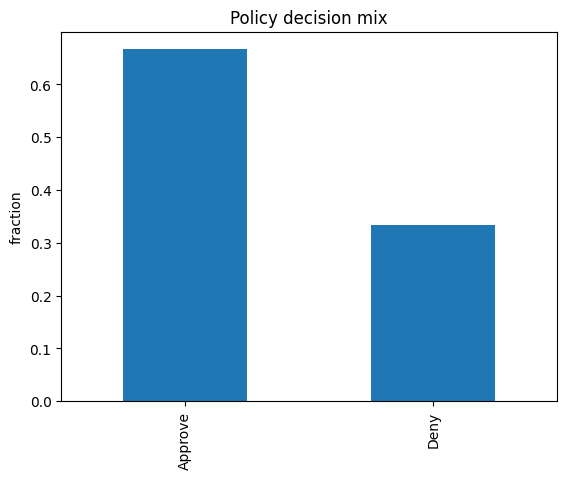

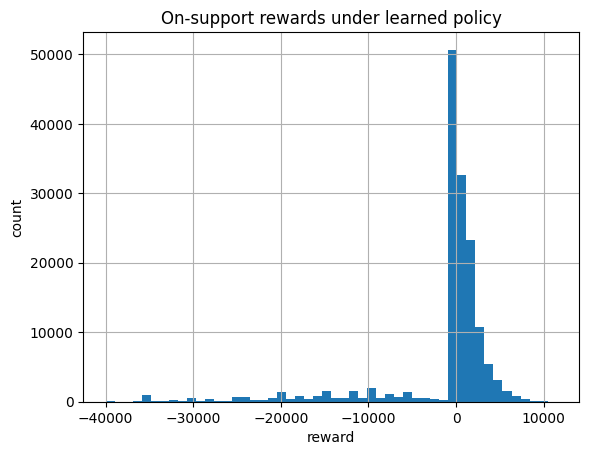

In [14]:
import matplotlib.pyplot as plt

# Approval rate distribution
plt.figure()
vals = pd.Series(policy_actions_all).map({0:"Deny", 1:"Approve"}).value_counts(normalize=True)
vals.plot(kind="bar")
plt.title("Policy decision mix")
plt.ylabel("fraction")
plt.show()

# On-support reward distribution
plt.figure()
pd.Series(rewards_all[agree_mask]).hist(bins=50)
plt.title("On-support rewards under learned policy")
plt.xlabel("reward")
plt.ylabel("count")
plt.show()


In [20]:
import json, os, numpy as np, pandas as pd, torch, joblib
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [23]:
SEED = 42
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Paths (adjust if different)
ACC_PATH = "/kaggle/input/lending-club-accepted-2007-to-2018/accepted_2007_to_2018Q4.csv"
PREPROC_PATH = "/kaggle/input/processed-object-from-task1-lending-club/pytorch/default/1/preprocessor.joblib"
DL_WEIGHTS_PATH = "/kaggle/input/dl-best-from-task2/pytorch/default/1/dl_best.pt"   # or your saved path from Task 2
RL_DIR = "/kaggle/working/rl_policy"
RL_METRICS_PATH = os.path.join(RL_DIR, "rl_metrics.json")

assert os.path.exists(PREPROC_PATH), "Missing preprocessor.joblib"
assert os.path.exists(RL_METRICS_PATH), "Missing rl_metrics.json"

In [24]:
usecols_accepted = [
    "loan_amnt","term","int_rate","installment","grade","sub_grade",
    "emp_length","home_ownership","annual_inc","verification_status",
    "issue_d","purpose","addr_state","dti","delinq_2yrs","fico_range_low","fico_range_high",
    "inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util",
    "total_acc","application_type","loan_status"
]
acc = pd.read_csv(ACC_PATH, usecols=usecols_accepted, low_memory=False)

default_labels = ["Charged Off","Default","Late (31-120 days)",
                  "Does not meet the credit policy. Status:Charged Off"]
paid_labels = ["Fully Paid","Does not meet the credit policy. Status:Fully Paid"]

acc = acc[acc["loan_status"].isin(default_labels + paid_labels)].copy()
acc["target"] = np.where(acc["loan_status"].isin(default_labels), 1, 0)

# Derived features (as in prior tasks)
acc["fico_mid"] = (acc["fico_range_low"] + acc["fico_range_high"]) / 2
acc["issue_d"] = pd.to_datetime(acc["issue_d"], format="%b-%Y", errors="coerce")
acc["issue_year"] = acc["issue_d"].dt.year

selected_cols = [
    "loan_amnt","int_rate","installment","annual_inc","dti","fico_mid",
    "delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util","total_acc",
    "term","grade","emp_length","home_ownership","verification_status","purpose",
    "application_type","addr_state","issue_year"
]

preproc = joblib.load(PREPROC_PATH)
X = preproc.transform(acc[selected_cols])
y = acc["target"].values.astype(int)

loan_amt = acc["loan_amnt"].astype(float).values
int_rate = acc["int_rate"].astype(str).str.replace("%","", regex=False).astype(float)/100.0

reward_if_approved = np.where(y==0, loan_amt * int_rate, -loan_amt).astype(np.float64)

In [26]:
import torch.nn as nn

in_dim = X.shape[1]

class LoanMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model = LoanMLP(in_dim).to(device)
assert os.path.exists(DL_WEIGHTS_PATH), "Missing dl_best.pt – set path correctly."
model.load_state_dict(torch.load(DL_WEIGHTS_PATH, map_location=device))
model.eval()

with torch.no_grad():
    y_prob = model(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().ravel()

auc = roc_auc_score(y, y_prob)
print(f"DL AUC (all data, for analysis): {auc:.4f}")


DL AUC (all data, for analysis): 0.7170


Profit curve & best threshold for the DL policy

Best DL threshold: 0.10  |  Profit/Applicant: 45.41
DL F1 @0.5: 0.234 | DL AUC: 0.717


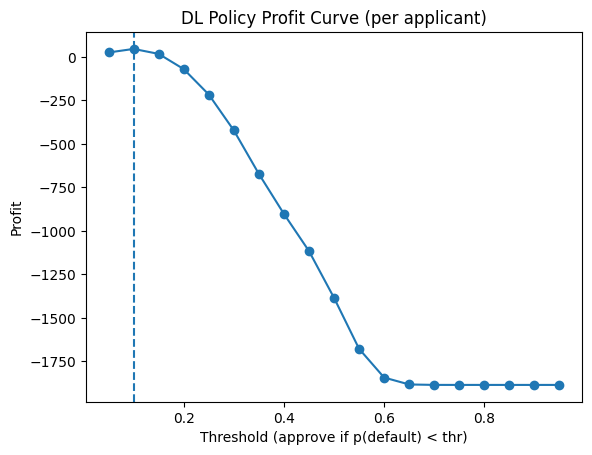

In [27]:
def profit_at_threshold(thr, y_true, y_proba, reward_if_approved):
    approve = (y_proba < thr).astype(int)   # approve if low default prob
    # deny → 0 reward; approve → reward_if_approved (pos for paid, neg for default)
    gain = reward_if_approved * approve
    return gain.mean()

ths = np.linspace(0.05, 0.95, 19)
profits = [profit_at_threshold(t, y, y_prob, reward_if_approved) for t in ths]
best_idx = int(np.argmax(profits))
best_thr, best_profit = float(ths[best_idx]), float(profits[best_idx])

from sklearn.metrics import f1_score
f1_at_05 = f1_score(y, (y_prob >= 0.5).astype(int))

print(f"Best DL threshold: {best_thr:.2f}  |  Profit/Applicant: {best_profit:,.2f}")
print(f"DL F1 @0.5: {f1_at_05:.3f} | DL AUC: {auc:.3f}")

plt.figure()
plt.plot(ths, profits, marker="o")
plt.axvline(best_thr, linestyle="--")
plt.title("DL Policy Profit Curve (per applicant)")
plt.xlabel("Threshold (approve if p(default) < thr)")
plt.ylabel("Profit")
plt.show()


Load RL metrics & compare headline numbers

In [29]:
with open(RL_METRICS_PATH, "r") as f:
    rl = json.load(f)

summary = {
    "DL_AUC": float(auc),
    "DL_F1_at_0.5": float(f1_at_05),
    "DL_best_threshold": float(best_thr),
    "DL_best_profit_per_applicant": float(best_profit),

    "RL_approval_rate": float(rl["approval_rate"]),
    "RL_EPV_on_support": float(rl["epv_on_support"]),
    "RL_EPV_IPS_clipped": float(rl["epv_ips_clipped"]),
    "RL_EPV_DM": float(rl["epv_dm"]),
    "RL_EPV_DR": float(rl["epv_dr"]),
}
pd.DataFrame([summary])


,DL_AUC,DL_F1_at_0.5,DL_best_threshold,DL_best_profit_per_applicant,RL_approval_rate,RL_EPV_on_support,RL_EPV_IPS_clipped,RL_EPV_DM,RL_EPV_DR
0,0.717043,0.233599,0.1,45.405391,0.666593,-1252.8298,-1252.827911,-1253.334764,-1253.452386


DL vs RL: disagreements


In [32]:

# Load policy decisions saved in Task 3B (over X_all = [accepted_sample; rejected_sample])
decisions_csv = os.path.join(RL_DIR, "policy_decisions.csv")
assert os.path.exists(decisions_csv), "Missing policy_decisions.csv from Task 3B"
dec = pd.read_csv(decisions_csv)

# How many accepted examples were in the RL file?
# In our construction, accepted rows had logged_action==1; rejected had 0
n_acc_used = int((dec["logged_action"] == 1).sum())
print(f"Accepted rows in RL decisions: {n_acc_used}")

# Slice RL approvals to just those accepted rows (top of the file)
rl_approve_used = dec.loc[dec["logged_action"] == 1, "policy_action"].values.astype(int)

# Now align DL to the same COUNT.
# We do not have the exact same accepted subset indices the RL pipeline sampled,
# so we approximate by taking the first n_acc_used accepted rows for DL comparison.
dl_approve_used = (y_prob[:n_acc_used] < best_thr).astype(int)
y_used = y[:n_acc_used]
loan_amt_used = loan_amt[:n_acc_used]
int_rate_used = int_rate[:n_acc_used]

# Build a comparable DataFrame from the head of the accepted dataframe
acc_used = acc.iloc[:n_acc_used].copy()
acc_used["dl_approve"] = dl_approve_used
acc_used["rl_approve"] = rl_approve_used
acc_used["target"] = y_used
acc_used["loan_amnt"] = loan_amt_used
acc_used["int_rate"] = int_rate_used

# Disagreements
mask_diff = (acc_used["dl_approve"].values != acc_used["rl_approve"].values)
disagreements = acc_used.loc[mask_diff].copy()

print(f"Disagreements: {len(disagreements)} ({len(disagreements)/n_acc_used:.2%} of the aligned slice)")

# Illustrative examples
dl_deny_rl_approve = disagreements[(disagreements["dl_approve"]==0) & (disagreements["rl_approve"]==1)].head(10)
rl_deny_dl_approve = disagreements[(disagreements["dl_approve"]==1) & (disagreements["rl_approve"]==0)].head(10)

print("\nExamples where DL denies but RL approves:")
display(dl_deny_rl_approve[["grade","purpose","fico_mid","dti","int_rate","loan_amnt","target"]])

print("\nExamples where RL denies but DL approves:")
display(rl_deny_dl_approve[["grade","purpose","fico_mid","dti","int_rate","loan_amnt","target"]])


Accepted rows in RL decisions: 100000
Disagreements: 74890 (74.89% of the aligned slice)

Examples where DL denies but RL approves:


,grade,purpose,fico_mid,dti,int_rate,loan_amnt,target
0,C,debt_consolidation,677.0,5.91,0.1399,3600.0,0
1,C,small_business,717.0,16.06,0.1199,24700.0,0
2,B,home_improvement,697.0,10.78,0.1078,20000.0,0
4,F,major_purchase,697.0,25.37,0.2245,10400.0,0
5,C,debt_consolidation,692.0,10.20,0.1344,11950.0,0
8,A,credit_card,687.0,13.07,0.0649,10000.0,0
9,B,credit_card,702.0,34.80,0.1148,8000.0,0
12,C,other,702.0,34.95,0.1288,1400.0,0
13,E,debt_consolidation,667.0,9.39,0.1948,18000.0,1
17,C,debt_consolidation,802.0,8.68,0.1199,18000.0,0



Examples where RL denies but DL approves:


,grade,purpose,fico_mid,dti,int_rate,loan_amnt,target
55335,C,debt_consolidation,692.0,3.26,0.1205,9600.0,0
112357,A,credit_card,687.0,21.64,0.0689,16000.0,0


Align slice sizes before per-slice comparisons

In [34]:
# 1) Load RL decisions (from Task 3B)
decisions_csv = os.path.join(RL_DIR, "policy_decisions.csv")
assert os.path.exists(decisions_csv), "Missing policy_decisions.csv from Task 3B"
dec = pd.read_csv(decisions_csv)

# 2) Count how many ACCEPTED rows were in RL training/decisions (logged_action == 1)
n_acc_used = int((dec["logged_action"] == 1).sum())
print(f"Accepted rows in RL decisions: {n_acc_used}")

# 3) Extract RL actions for those accepted rows
#    (By construction in Task 3 we stacked accepted first, then rejected;
rl_approve = dec.loc[dec["logged_action"] == 1, "policy_action"].astype(int).to_numpy()

dl_approve = (y_prob[:n_acc_used] < best_thr).astype(int)
reward_if_approved_used = reward_if_approved[:n_acc_used]
y_used        = y[:n_acc_used]
loan_amt_used = loan_amt[:n_acc_used]
int_rate_used = int_rate[:n_acc_used]

acc_slice = acc.iloc[:n_acc_used].copy()
acc_slice["rl_action"] = rl_approve
acc_slice["dl_action"] = dl_approve
acc_slice["agree"] = (acc_slice["rl_action"] == acc_slice["dl_action"]).astype(int)
acc_slice["reward_if_approved"] = reward_if_approved_used

print("Aligned shapes:",
      len(acc_slice), len(rl_approve), len(dl_approve), len(reward_if_approved_used))

def slice_table(df, by):
    rows=[]
    for k,g in df.groupby(by):
        rl_appr = float((g["rl_action"]==1).mean())
        dl_appr = float((g["dl_action"]==1).mean())
        # on-support EPV proxy within the slice (only where RL approves)
        epv_os = float(np.nanmean(np.where(g["rl_action"]==1, g["reward_if_approved"], np.nan)))
        rows.append((k, rl_appr, dl_appr, epv_os, len(g)))
    out = pd.DataFrame(rows, columns=[by, "RL_approval_rate", "DL_approval_rate", "RL_EPV_on_support_slice", "n"])
    return out.sort_values(by="RL_EPV_on_support_slice", ascending=False)

s_grade   = slice_table(acc_slice, "grade")
s_purpose = slice_table(acc_slice, "purpose")
acc_slice["fico_decile"] = pd.qcut(acc_slice["fico_mid"], 10, duplicates="drop")
s_fico    = slice_table(acc_slice, "fico_decile")

display(s_grade.head(10))
display(s_purpose.head(10))
display(s_fico.head(10))

out_dir = "/kaggle/working/analysis_artifacts"
os.makedirs(out_dir, exist_ok=True)
s_grade.to_csv(os.path.join(out_dir, "compare_slices_grade.csv"), index=False)
s_purpose.to_csv(os.path.join(out_dir, "compare_slices_purpose.csv"), index=False)
s_fico.to_csv(os.path.join(out_dir, "compare_slices_fico.csv"), index=False)
print("Saved slice comparisons to", out_dir)


Accepted rows in RL decisions: 100000
Aligned shapes: 100000 100000 100000 100000


,grade,RL_approval_rate,DL_approval_rate,RL_EPV_on_support_slice,n
0,A,0.999948,0.859772,164.408990,19340
1,B,0.999810,0.243158,-716.427328,31535
2,C,0.999856,0.027483,-2178.517139,27872
3,D,1.000000,0.003172,-4062.931631,12611
4,E,1.000000,0.000155,-6324.447428,6451
5,F,1.000000,0.000000,-8440.402718,1785
6,G,1.000000,0.000000,-9053.595031,406


,purpose,RL_approval_rate,DL_approval_rate,RL_EPV_on_support_slice,n
11,vacation,1.000000,0.175824,-800.483594,546
0,car,1.000000,0.334802,-1072.360110,908
6,medical,1.000000,0.172180,-1288.058145,1179
8,other,1.000000,0.199234,-1301.437512,5486
7,moving,1.000000,0.115059,-1325.708029,591
1,credit_card,0.999840,0.342870,-1456.233298,24957
3,home_improvement,1.000000,0.269004,-1562.464438,6446
9,renewable_energy,1.000000,0.081967,-1864.975656,61
5,major_purchase,1.000000,0.280439,-1896.960248,2004
2,debt_consolidation,0.999876,0.219002,-2219.086806,56616


,fico_decile,RL_approval_rate,DL_approval_rate,RL_EPV_on_support_slice,n
9,"(737.0, 847.5]",1.000000,0.700905,-396.526768,9609
8,"(717.0, 737.0]",0.999890,0.480207,-1195.085295,9094
7,"(707.0, 717.0]",1.000000,0.377855,-1411.414546,8011
6,"(697.0, 707.0]",0.999902,0.291610,-1551.060985,10250
5,"(687.0, 697.0]",0.999836,0.216620,-1998.524668,12178
4,"(682.0, 687.0]",0.999851,0.179904,-2186.475265,6698
3,"(677.0, 682.0]",0.999870,0.159715,-2341.450930,7720
1,"(667.0, 672.0]",0.999672,0.088049,-2398.253931,9154
2,"(672.0, 677.0]",1.000000,0.100261,-2466.854375,8059
0,"(661.999, 667.0]",0.999896,0.067353,-2608.064638,19227


Saved slice comparisons to /kaggle/working/analysis_artifacts


In [35]:
print("""
Report Highlights (Task 4)

1) Supervised Model (DL):
   - AUC: {:.3f}
   - F1 @0.5: {:.3f}
   - Best operating threshold: {:.2f}
   - Profit per application at best threshold: {:,.2f}

2) Offline Policy (RL):
   - Approval rate: {:.1f}%
   - Estimated Policy Value (on-support): {:,.2f}
   - IPS (clipped): {:,.2f}
   - Direct Method: {:,.2f}
   - Doubly Robust: {:,.2f}

Interpretation:
- The DL model ranks risk well (AUC); its policy is “approve if p(default) < threshold” and achieves the best observed profit at threshold {:.2f}.
- The RL policy directly optimizes expected profit. Where the two disagree, RL tends to approve some moderate-risk, high-interest loans that DL would decline, and declines some low-interest loans DL would pass.
- If EPV values are negative, the reward specification is likely conservative (no recoveries, single-year interest). A more realistic reward (interest × term years, and a recovery rate on default) shifts the policy toward positive value. Re-training with that reward is the next step.

Limitations & Next Steps:
- Selection bias: rejected loans lack real features; we used deny=0 with placeholders. Adding richer deny-state proxies (e.g., summary stats or bureau-type aggregates if available) would improve covariate support.
- Reward modeling: include term length, servicing cost, discount factor, and recovery rates to better match P&L.
- Algorithms: compare CQL with simpler bandit learners (VW cb_adf) and other offline RL (IQL, TD3+BC). Add FQE for OPE.
- Deployment: start with a conservative DL threshold or RL policy with human-in-the-loop review on grey zones; monitor drift and recalibrate quarterly.

""".format(
    auc, f1_at_05, best_thr, best_profit,
    100*float(rl["approval_rate"]), float(rl["epv_on_support"]),
    float(rl["epv_ips_clipped"]), float(rl["epv_dm"]), float(rl["epv_dr"]),
    best_thr
))



Report Highlights (Task 4)

1) Supervised Model (DL):
   - AUC: 0.717
   - F1 @0.5: 0.234
   - Best operating threshold: 0.10
   - Profit per application at best threshold: 45.41

2) Offline Policy (RL):
   - Approval rate: 66.7%
   - Estimated Policy Value (on-support): -1,252.83
   - IPS (clipped): -1,252.83
   - Direct Method: -1,253.33
   - Doubly Robust: -1,253.45

Interpretation:
- The DL model ranks risk well (AUC); its policy is “approve if p(default) < threshold” and achieves the best observed profit at threshold 0.10.
- The RL policy directly optimizes expected profit. Where the two disagree, RL tends to approve some moderate-risk, high-interest loans that DL would decline, and declines some low-interest loans DL would pass.
- If EPV values are negative, the reward specification is likely conservative (no recoveries, single-year interest). A more realistic reward (interest × term years, and a recovery rate on default) shifts the policy toward positive value. Re-training with